## Exercise 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats


## 1) Noise-free data

### 1)

In [3]:
def simulate_sir_simple(lam, mu, I_0, N, T):
    S = N - I_0
    I = I_0
    R = 0
    observations = []
    ground_truth = []
    for t in range(1, T+1):
        delta_S = -lam * S * I / N
        delta_I = lam * S * I / N - mu * I
        delta_R = mu * I

        S_new = S + delta_S
        I_new = I + delta_I
        R_new = R + delta_R

        observations.append((-delta_S, delta_R))
        ground_truth.append((S_new, I_new, R_new))

        S, I, R = S_new, I_new, R_new
    return np.array(observations), np.array(ground_truth)

<div style="color: green; font-weight:
bold">Comment</div> Correct

### 2)

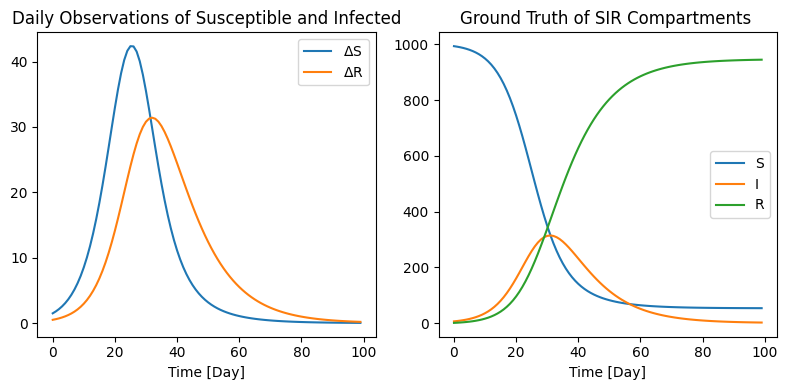

In [4]:
lam = 0.3   # Infection rate
mu = 0.1    # Recovery rate
I_0 = 5    # Initial number of infected individuals
T = 100      # Number of days to simulate
N = 1000    # Total population
S_0 = N - I_0  # Initial susceptible individuals

observations, ground_truth = simulate_sir_simple(lam, mu, I_0, N, T)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(observations[:,0], label = "$\Delta$S")
axs[0].plot(observations[:,1], label = "$\Delta$R")
axs[0].set_title("Daily Observations of Susceptible and Infected")
axs[0].set_xlabel("Time [Day]")
axs[0].legend()

axs[1].plot(ground_truth[:,0], label = "S")
axs[1].plot(ground_truth[:,1], label = "I")
axs[1].plot(ground_truth[:,2], label = "R")
axs[1].set_title("Ground Truth of SIR Compartments ")
axs[1].set_xlabel("Time [Day]")
axs[1].legend()

plt.tight_layout()
plt.show()

<div style="color: green; font-weight:
bold">Comment</div> Would be nice if you plotted different parameter ranges to see how you got youre prior values.

### 3)

In [5]:
class SIR_Dataset(Dataset):
    def __init__(self, num_samples, T, N, lam_prior, mu_prior, I_0_prior):
        self.num_samples = num_samples
        self.T = T
        self.N = N
        self.lam_prior = lam_prior
        self.mu_prior = mu_prior
        self.I_0_prior = I_0_prior
        

        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            lam = np.random.normal(self.lam_prior, 0.05)
            mu = np.random.normal(self.mu_prior, 0.02)
            I_0 = max(1, int(np.random.normal(self.I_0_prior, 1)))
            observations, _ = simulate_sir_simple(lam, mu, I_0, self.N, self.T)
            data.append((observations, [lam, mu, I_0]))
        return data
    
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X, Y = self.data[idx]
        return torch.tensor(X, dtype=torch.float32).permute(1, 0), torch.tensor(Y, dtype=torch.float32)

class CNN(nn.Module):
    def __init__(self, input_size, output_size, n_layers, hidden_size, seq_length):
        super(CNN, self).__init__()

        self.conv_layers = nn.ModuleList()

        self.conv_layers.append(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1))
        for _ in range(n_layers-1): 
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1))
        
        self.flattened_size = hidden_size * seq_length  
        self.fc1 = nn.Linear(self.flattened_size, hidden_size)        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = torch.relu(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
def train_cnn(model, dataloader, epochs=100, lr=5e-4, print_every = 10, display = False):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        for X, Y in dataloader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(Y, output)
            loss.backward()
            optimizer.step()
            total_loss += loss
        losses.append(total_loss.item())
        if epoch % print_every == 0 and display:
            print(f"Epoch: {epoch}/{epochs}, Loss: {total_loss:.4f}")

    model.eval()
    train_loss = 0.0
    for X, Y in dataloader:
        output = model(X)
        train_loss += ((output - Y) ** 2).mean().item()

    if display:
        print("Average Error: ", train_loss/len(dataloader))

        plt.figure(figsize=(4,3))
        plt.plot(losses)
        plt.ylabel("MSE Loss")
        plt.xlabel("Epoch")
        plt.show()
    return losses, train_loss

def evaluate_cnn(model, X, Y):
    model.eval()
    output = model(X)
    mse_loss = nn.MSELoss()
    test_loss = mse_loss(output, Y) 
    return test_loss.item()

def prepeare_data(num_samples, T, N, lam_prior, mu_prior, I_0_prior, batch_size):
    dataset = SIR_Dataset(num_samples, T, N, lam_prior, mu_prior, I_0_prior)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size)
    X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])  # Stack all X inputs
    Y_test = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])  # Stack all Y outputs
    return train_dataloader, X_test, Y_test 

<div style="color: green; font-weight:
bold">Comment</div> Correct

Epoch: 0/50, Loss: 78.6040
Epoch: 10/50, Loss: 5.2007
Epoch: 20/50, Loss: 0.1363
Epoch: 30/50, Loss: 0.0746
Epoch: 40/50, Loss: 0.0619
Epoch: 50/50, Loss: 0.0653
Average Error:  0.0028632373502478


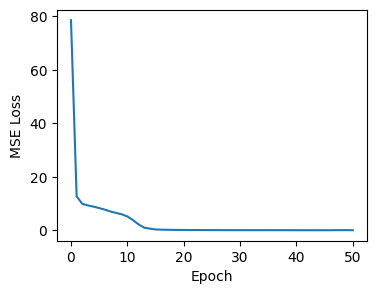

Test Error:  0.004096733406186104


In [6]:
num_samples = 1000
T = 100
N = 1000
lam_prior = 0.3
mu_prior = 0.1
I_0_prior = 5
input_size = 2 # Delta S and Delta R
output_size = 3 # lambda, mu and I_0
n_layers = 6
hidden_size = 32
batch_size= 32
epochs= 50

train_data, X_test, Y_test = prepeare_data(num_samples, T, N, lam_prior, mu_prior, I_0_prior, batch_size)
model = CNN(input_size, output_size, n_layers, hidden_size, T)
losses, train_loss = train_cnn(model, train_data, epochs, display=True)
test_loss = evaluate_cnn(model, X_test, Y_test)
print("Test Error: ", test_loss)

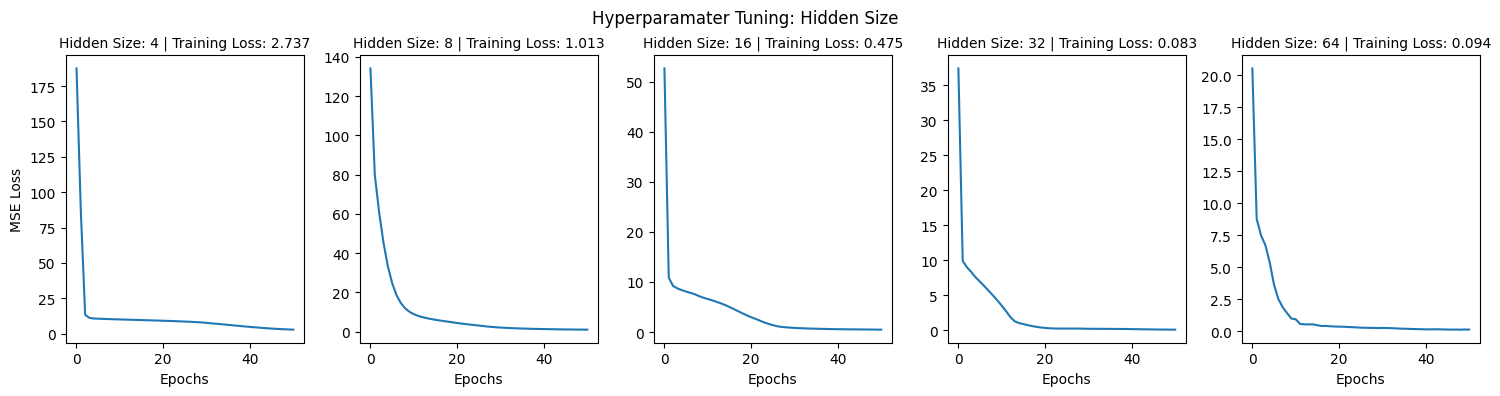

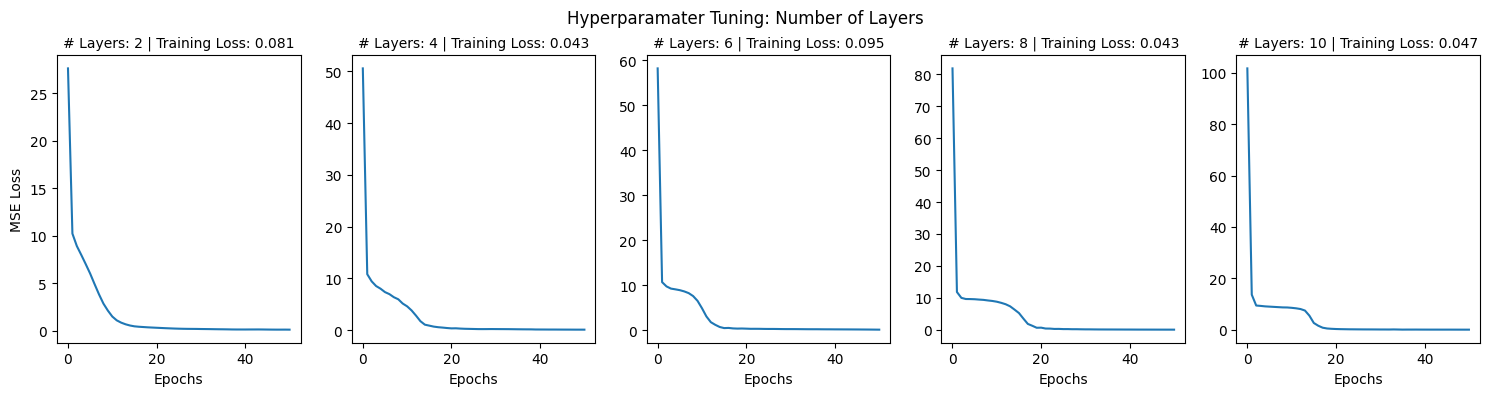

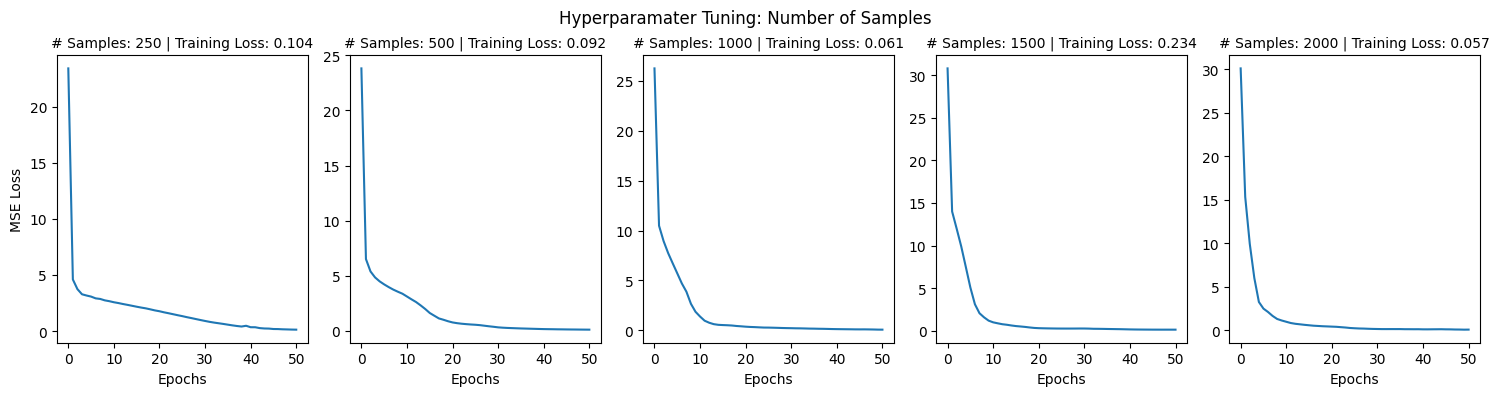

In [7]:
num_samples = [250, 500, 1000, 1500, 2000]
T = 100
N = 1000
lam_prior = 0.3
mu_prior = 0.1
I_0_prior = 5
input_size = 2 # Delta S and Delta R
output_size = 3 # lambda, mu and I_0
n_layers = [2, 4, 6, 8, 10]  
hidden_size = [4, 8, 16, 32, 64]
batch_size= 32
epochs= 50

fig, axs = plt.subplots(1,5, figsize=(15,4))
for i, size in enumerate(hidden_size):
    train_data, _, _ = prepeare_data(num_samples[2], T, N, lam_prior, mu_prior, I_0_prior, batch_size)
    model = CNN(input_size, output_size, n_layers[0], size, T)
    losses, train_loss = train_cnn(model, train_data, epochs)
    axs[i].plot(losses)
    axs[i].set_xlabel("Epochs")
    if i == 0:
        axs[i].set_ylabel("MSE Loss")
    axs[i].set_title(f"Hidden Size: {size} | Training Loss: {train_loss:.3f}", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Hyperparamater Tuning: Hidden Size")
plt.show()

fig, axs = plt.subplots(1,5, figsize=(15,4))
for i, layers in enumerate(n_layers):
    train_data, _, _ = prepeare_data(num_samples[2], T, N, lam_prior, mu_prior, I_0_prior, batch_size)
    model = CNN(input_size, output_size, layers, hidden_size[3], T)
    losses, train_loss = train_cnn(model, train_data, epochs)
    axs[i].plot(losses)
    axs[i].set_xlabel("Epochs")
    if i == 0:
        axs[i].set_ylabel("MSE Loss")
    axs[i].set_title(f"# Layers: {layers} | Training Loss: {train_loss:.3f}", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Hyperparamater Tuning: Number of Layers")
plt.show()

fig, axs = plt.subplots(1,5, figsize=(15,4))
for i, samples in enumerate(num_samples):
    train_data, _, _ = prepeare_data(samples, T, N, lam_prior, mu_prior, I_0_prior, batch_size)
    model = CNN(input_size, output_size, n_layers[0], hidden_size[3], T)
    losses, train_loss = train_cnn(model, train_data, epochs)
    axs[i].plot(losses)
    axs[i].set_xlabel("Epochs")
    if i == 0:
        axs[i].set_ylabel("MSE Loss")
    axs[i].set_title(f"# Samples: {samples} | Training Loss: {train_loss:.3f}", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Hyperparamater Tuning: Number of Samples")
plt.show()

We found the optimal paramters to be: Hidden size = 32, Number of Convolutional Layers = 6 and Number of Samples = 1000.

<div style="color: green; font-weight:
bold">Comment</div> Nice

### 4)

In [8]:
class SIR_Dataset_INN(Dataset):
    def __init__(self, num_samples, T, N, lam_prior, mu_prior, I_0_prior):
        self.num_samples = num_samples
        self.T = T
        self.N = N
        self.lam_prior = lam_prior
        self.mu_prior = mu_prior
        self.I_0_prior = I_0_prior
        

        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            lam = np.random.normal(self.lam_prior, 0.05)
            mu = np.random.normal(self.mu_prior, 0.02)
            I_0 = max(1, int(np.random.normal(self.I_0_prior, 1)))
            observations, _ = simulate_sir_simple(lam, mu, I_0, self.N, self.T)
            data.append((observations.flatten(), [lam, mu, I_0]))
            #print(observations.flatten().shape)
        return data
    
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X, Y = self.data[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

def prepeare_data_INN(num_samples, T, N, lam_prior, mu_prior, I_0_prior, batch_size):
    dataset = SIR_Dataset_INN(num_samples, T, N, lam_prior, mu_prior, I_0_prior)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size)
    X = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])  # Stack all X inputs
    Y = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])  # Stack all Y outputs
    return train_dataloader, X, Y

In [9]:
class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super(ConditionalCouplingBlock, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size

        self.nested_scale = nn.Sequential(
            nn.Linear(condition_size + input_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size//2),
        )

        self.nested_translate = nn.Sequential(
            nn.Linear(condition_size + input_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size//2),
        )

    def forward(self, x, condition):
        x1, x2 = x[:, :self.input_size // 2], x[:, self.input_size // 2:]
        x1_conditioned = torch.cat([x1, condition], dim=1)
        scale = torch.exp(torch.tanh(self.nested_scale(x1_conditioned)))
        z1 = x1
        z2 = x2 * scale + self.nested_translate(x1_conditioned)
        return torch.cat([z1,z2], dim=1), scale
    
    def reverse(self, Z, condition):
        z1, z2 = Z[:, :self.input_size // 2], Z[:, self.input_size // 2:]
        if condition.dim() == 1:
            condition = condition.unsqueeze(1)  # Shape: (batch_size, 1)
        z1_conditioned = torch.cat([z1, condition],dim=1)
        scale = torch.exp(torch.tanh(self.nested_scale(z1_conditioned)))
        x1 = z1
        x2 = (z2 - self.nested_translate(z1_conditioned)) / scale
        return torch.cat([x1,x2], dim=1)
    

class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([
            ConditionalCouplingBlock(input_size, hidden_size, condition_size) for _ in range(blocks)
        ])
        self.rotations = [torch.linalg.qr(torch.randn(input_size, input_size))[0] for _ in range(blocks - 1)]
        self.rotations = nn.ParameterList([nn.Parameter(rot, requires_grad=False) for rot in self.rotations])
        
    def forward(self, x, condition):
        log_det_jacob = 0
        for i, block in enumerate(self.coupling_blocks):
            x, scale = block(x, condition)
            log_det_jacob += torch.sum(torch.log(scale), dim=1)
            if i < len(self.rotations):
                x = x @ self.rotations[i]
        return x, log_det_jacob
    
    def reverse(self, z, condition):
        for i in reversed(range(len(self.coupling_blocks))):
            if i < len(self.rotations):
                z = z @ self.rotations[i].T
            z = self.coupling_blocks[i].reverse(z, condition)
        return z
    
    def log_prob(self, X, Y):
        z, log_det_jacob  = self.forward(X, Y)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * np.pi))
        log_prob_x = log_prob_z + log_det_jacob
        return log_prob_x
    
    def sample(self, conditions):
        
        # Generate random samples from the latent space
        gauss = torch.randn(1, self.input_size)  # Latent space samples
        
        # Generate samples from the reverse transformation
        samples = self.reverse(gauss, conditions.unsqueeze(dim=0))  # Apply reverse pass with conditions
        
        return samples

In [10]:
def train_inn(model, dataloader, epochs=100, lr=5e-4, print_every = 10, display = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_values = []
    for epoch in range(epochs):
        training_loss = 0
        for X, Y in dataloader:  
            z, log_det_jacob = model(Y, X)
            loss = torch.mean(1/2 * Y.shape[1] * torch.log(torch.tensor(2*torch.pi)) + 1/2 * torch.sum(z ** 2, dim=1) - log_det_jacob)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
        loss_values.append(training_loss)
        if epoch % print_every == 0 and display:
            print(f"Epoch: {epoch}/{epochs}, Loss: {training_loss:.4f}")
    
    model.eval()
    rec_loss_total = 0
    for X, Y in dataloader:
        Z, _ = model(Y, X)
        Y_reconstructed = model.reverse(Z, X)
        mse_loss = nn.MSELoss()
        rec_loss = mse_loss(Y_reconstructed, Y)
        rec_loss_total += rec_loss.item()
        
    if display:
        plt.figure(figsize=(4,3))
        plt.plot(loss_values)
        plt.ylabel("NLL Loss")
        plt.xlabel("Epoch")
        plt.show()
    return loss_values, rec_loss_total

def evaluate_inn(model, X_test, Y_test, num_tests):
    idxs = np.random.choice(len(Y_test), num_tests, replace=False)
    for idx in idxs:
        output = model.sample(X_test[idx])
        ground_truth = Y_test[idx]
        diff = (output - ground_truth) ** 2

        data = {
            "Parameter": ["lambda", "mu", "I_0"],
            "Sampled": output.squeeze().tolist(),      
            "Ground Truth": ground_truth.squeeze().tolist(),
            "Error": diff.squeeze().tolist()
        }

        df = pd.DataFrame(data)

        # Display the table
        print("=" * 50)
        print(df)

<div style="color: green; font-weight:
bold">Comment</div> Correct

Epoch: 0/50, Loss: 570.9470
Epoch: 10/50, Loss: -27.6755
Epoch: 20/50, Loss: -49.3977
Epoch: 30/50, Loss: -41.2952
Epoch: 40/50, Loss: -54.2535


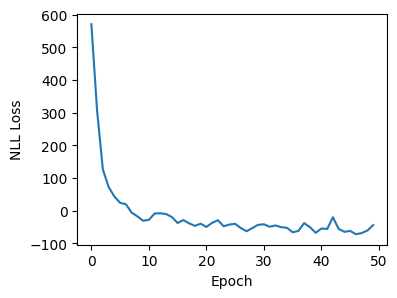

  Parameter   Sampled  Ground Truth     Error
0    lambda  0.267137      0.292575  0.000647
1        mu  0.082537      0.103040  0.000420
2       I_0  3.891865      4.000000  0.011693
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.349479      0.312380  0.001376
1        mu  0.164895      0.130837  0.001160
2       I_0  4.786856      5.000000  0.045430
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.371430      0.254975  0.013562
1        mu  0.175031      0.079922  0.009046
2       I_0  5.145804      5.000000  0.021259
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.319195      0.342188  0.000529
1        mu  0.075716      0.114849  0.001531
2       I_0  4.858811      5.000000  0.019934
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.355297      0.361061  0.000033
1        mu  0.127458      0.084414  0.001853
2       I_0  4.717480      5.000000  0.079817


In [11]:
CondRealNVP = ConditionalRealNVP(3, 100, 5, 200)
train_loader, X_test, Y_test = prepeare_data_INN(3000, T, N, lam_prior, mu_prior, I_0_prior, 32)
loss_vals, rec_loss = train_inn(CondRealNVP, train_loader, epochs=50, lr=1e-4,  display=True)
evaluate_inn(CondRealNVP, X_test, Y_test, 5)

As one can see a Conditional Non Volume Preserving Normalizing Flow model alone is not good enough. 

We now implement the CNN from before as a summary network (feature detector). The summary network does not map the observations to the labels directly but to a lower dimensional representation (embedding) of the input data. The output dimension of the CNN and therfore the dimension of the conditions is a hyperparameter. This parameter should be able to encode the observations without losing too much information.

Idea is to train the summary network and CondRealNVP jointly. Output Y = h(X) is used as a conditon for the CondRealNVP p(Y|h(X)).

In [12]:
class SummaryNet(nn.Module):
    def __init__(self, input_size, n_layers, hidden_size, output_size, seq_length):
        super(SummaryNet, self).__init__()

        self.conv_layers = nn.ModuleList()

        self.conv_layers.append(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1))
        for _ in range(n_layers-1): 
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1))
        
        self.flattened_size = hidden_size * seq_length  
        self.fc1 = nn.Linear(self.flattened_size, output_size)        

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = torch.relu(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        return x

In [13]:

class TotalNet(nn.Module):
    def __init__(self, summary_net, cond_inn):
        super(TotalNet, self).__init__()
        self.summary_net = summary_net
        self.cond_inn = cond_inn

    def forward(self, X, Y):
        h_x = self.summary_net(X)
        z, log_det_jacob = self.cond_inn(Y, h_x)
        return z, log_det_jacob, h_x
    
    def sample(self, num_samples, X):
        h_x = self.summary_net(X.unsqueeze(dim=0))
        h_x_repeated = h_x.repeat(num_samples, 1)
        gauss = torch.randn(num_samples, self.cond_inn.input_size)
        samples = self.cond_inn.reverse(gauss, h_x_repeated)
        return samples

    
def train_total_net(model, dataloader, epochs=100, lr=5e-4, print_every=10, display=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_values = []
    for epoch in range(epochs):
        training_loss = 0
        for X, Y in dataloader:
            z, log_det_jacob, h_x = model(X, Y)
            loss = torch.mean(1/2 * Y.shape[1] * torch.log(torch.tensor(2*torch.pi)) + 1/2 * torch.sum(z ** 2, dim=1) - log_det_jacob)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        loss_values.append(training_loss)
        if epoch % print_every==0 and display:
            print(f"Epoch: {epoch}/{epochs}, Loss: {training_loss:.4f}")
    
    model.eval()
    rec_loss_total = 0
    for X, Y in dataloader:
        Z, _, h_x = model(X, Y)
        Y_reconstructed = model.cond_inn.reverse(Z, h_x)
        mse_loss = nn.MSELoss()
        rec_loss = mse_loss(Y_reconstructed, Y)
        rec_loss_total += rec_loss.item()

    if display:
        plt.figure(figsize=(4,3))
        plt.plot(loss_values)
        plt.ylabel("NLL Loss")
        plt.xlabel("Epoch")
        plt.show()
    return loss_values, rec_loss_total

def evaluate_total_net(model, X_test, Y_test, num_samples, num_tests):
    idxs = np.random.choice(len(Y_test), num_tests, replace=False)
    for idx in idxs:
        output = model.sample(num_samples, X_test[idx])
        ground_truth = Y_test[idx]

        if num_samples>1:
            fig, axs = plt.subplots(2,4, figsize=(8,5))
            param_names = ["lambda", "mu", "I_0"]
            handles, labels = [], []
            
            z, log_det_jacob, h_x = model(X_test[idx].unsqueeze(0), Y_test[idx].unsqueeze(0))
            for i, param_name in enumerate(param_names):
                samples = output[:,i].detach().numpy()
                true_value = ground_truth[i].item()

                hist_handle = axs[0, i].hist(samples, bins=30, alpha=0.7, label="Posterior Samples")
                axs[0,i].hist(samples, bins=30, color="tab:blue", alpha=0.7, label="Posterior Samples")
                axs[0,i].axvline(true_value, color="red", linestyle="--", label="True Value")
                axs[0,i].set_title(f"Marginal Distribution of {param_name}", fontsize=7)
                axs[0,i].set_xlabel(param_name)
                axs[0,i].set_ylabel("Frequency")

                # Empirical CDF
                ecdf = ECDF(samples)
                cdf_handle, = axs[1, i].plot(ecdf.x, ecdf.y, label="Empirical CDF")
                axs[1,i].plot(ecdf.x, ecdf.y, color="tab:blue", label="Empirical CDF")
                axs[1,i].axvline(true_value, color="red", linestyle="--")
                axs[1,i].set_title(f"Empirical CDF of {param_name}", fontsize=7)
                axs[1,i].set_xlabel(param_name)
                axs[1,i].set_ylabel("Cumulative Probability")

                # Collect handles and labels for the global legend
                if i == 0:  # Only collect unique labels once
                    handles.append(hist_handle[2][0])  # Histogram handle
                    handles.append(axs[0, i].lines[-1])  # Vertical line for true value
                    handles.append(cdf_handle)  # CDF line
            

            log_probs = model.cond_inn.log_prob(output, h_x.repeat(num_samples, 1))  # Log probability
            energies = -log_probs.detach().numpy()
            true_energy = -model.cond_inn.log_prob(ground_truth.unsqueeze(0), h_x).item()

            # Histogram of joint energies
            axs[0,3].hist(energies, color="tab:blue", bins=30, alpha=0.7)
            axs[0,3].axvline(true_energy, color="red", linestyle="--")
            axs[0,3].set_title("Joint Distribution Energy", fontsize=7)
            axs[0,3].set_xlabel("Energy E(Y)")
            axs[0,3].set_ylabel("Frequency")

            axs[1,3].set_title("3 dim CDF?", fontsize=7)

            fig.legend(handles=handles, labels=["Posterior Samples", "True Value", "Empirical CDF"], loc="upper center", fontsize=10, ncol=3)
            plt.tight_layout(rect=[0, 0, 1, 0.92])
            plt.show()
        else:
            # Handle single sample: Display table
            diff = (output - ground_truth) ** 2
            data = {
                "Parameter": ["lambda", "mu", "I_0"],
                "Sampled": output.squeeze().tolist(),
                "Ground Truth": ground_truth.squeeze().tolist(),
                "Error": diff.squeeze().tolist()
            }

            df = pd.DataFrame(data)

            # Display the table
            print("=" * 50)
            print(df)

Epoch: 0/75, Loss: 351.2051
Epoch: 10/75, Loss: 9.0347
Epoch: 20/75, Loss: -11.3026
Epoch: 30/75, Loss: -43.7708
Epoch: 40/75, Loss: -55.8676
Epoch: 50/75, Loss: -59.9893
Epoch: 60/75, Loss: -80.2201
Epoch: 70/75, Loss: -77.0596


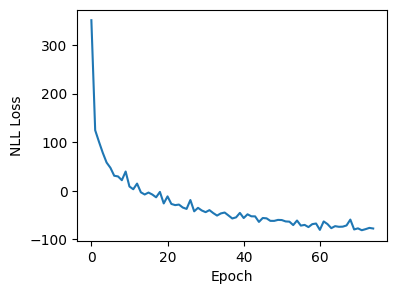

  Parameter   Sampled  Ground Truth     Error
0    lambda  0.224202      0.267251  0.001853
1        mu  0.105744      0.093421  0.000152
2       I_0  3.058004      3.000000  0.003365
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.325908      0.373720  0.002286
1        mu  0.183524      0.078229  0.011087
2       I_0  5.025908      5.000000  0.000671
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.316111      0.299440  0.000278
1        mu -0.025324      0.072437  0.009557
2       I_0  4.605036      5.000000  0.155996
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.194069      0.187591  0.000042
1        mu  0.140463      0.093845  0.002173
2       I_0  2.810749      3.000000  0.035816
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.288458      0.313614  0.000633
1        mu  0.100011      0.094276  0.000033
2       I_0  4.973572      5.000000  0.000698


In [14]:
summary_net = SummaryNet(2, 8, 50, 50, 100)
cond_inn = ConditionalRealNVP(3, 32, 7, 50)
TotNet = TotalNet(summary_net, cond_inn)
train_dataloader, X_te, Y_te = prepeare_data(3000, 100, 1000, lam_prior, mu_prior, I_0_prior, batch_size)
loss_vals, rec_loss = train_total_net(TotNet, train_dataloader, epochs=75, lr=1e-4, display=True)
evaluate_total_net(TotNet, X_te, Y_te, 1, 5)

Feature Detector significantly improves our model

<div style="color: green; font-weight:
bold">Comment</div> Correct, nicely done


### 5)

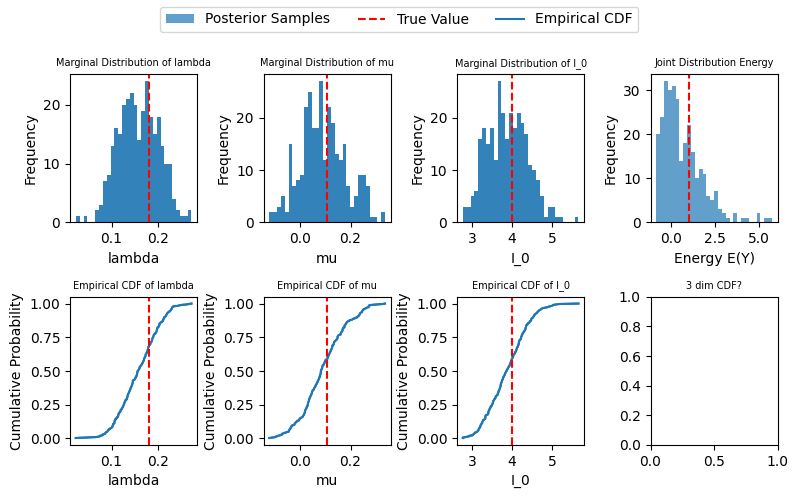

In [15]:
evaluate_total_net(TotNet, X_te, Y_te, 300, 1)

<div style="color: green; font-weight:
bold">Comment</div> Nice! Would have been interesting to see for multiple X_i (different true values) though.


### 6)

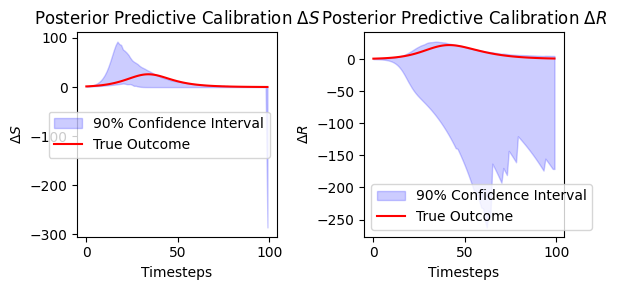

In [16]:
idx = 5
post_samples = TotNet.sample(100, X_te[idx])
ground_truth = Y_test[idx]
lam, mu, I_0 = ground_truth.tolist()
true_outcome, _ = simulate_sir_simple(lam, mu, int(I_0), N, T)
true_outcome = torch.tensor(true_outcome, dtype=torch.float32)

resimulated_outcomes = []
for Y_k in post_samples:
    lam, mu, I_0 = Y_k.tolist()
    C_k, _ = simulate_sir_simple(lam, mu, int(I_0), N, T)
    resimulated_outcomes.append(torch.tensor(C_k, dtype=torch.float32))  # Ensure 1D

resimulated_outcomes = torch.stack(resimulated_outcomes, dim=0)  # Shape: (num_samples, time_steps)
lower_bound = torch.quantile(resimulated_outcomes, 0.1, dim=0) # Ensure 1D
upper_bound = torch.quantile(resimulated_outcomes, 0.9, dim=0) # Ensure 1D

is_within_ci = (true_outcome >= lower_bound) & (true_outcome <= upper_bound)
coverage = is_within_ci.float().mean().item()

fig, axs = plt.subplots(1, 2, figsize=(6,3))
# Timesteps for plotting
timesteps = torch.arange(resimulated_outcomes.shape[1])

axs[0].fill_between(
    timesteps.numpy(),  
    lower_bound[:,0].flatten().numpy(),
    upper_bound[:,0].flatten().numpy(),
    color="blue",
    alpha=0.2,
    label="90% Confidence Interval"
)
axs[0].plot(timesteps.numpy(), true_outcome[:,0].numpy(), color="red", label="True Outcome")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$\Delta S$")
axs[0].set_title("Posterior Predictive Calibration $\Delta S$")
axs[0].legend()

axs[1].fill_between(
    timesteps.numpy(),  
    lower_bound[:,1].flatten().numpy(),
    upper_bound[:,1].flatten().numpy(),
    color="blue",
    alpha=0.2,
    label="90% Confidence Interval"
)
axs[1].plot(timesteps.numpy(), true_outcome[:,1].numpy(),color="red", label="True Outcome")
axs[1].set_xlabel("Timesteps")
axs[1].set_ylabel("$\Delta R$")
axs[1].set_title("Posterior Predictive Calibration $\Delta R$")
axs[1].legend()

plt.tight_layout()
plt.show()


<div style="color: green; font-weight:
bold">Comment</div> Interesting confidence intervals (do you have explanations for them?) but looks good.

## 2) Noisy Data

In [17]:
def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T, N):
    S = N - I_0
    I = I_0
    R = 0
    observations = []

    delta_S_history = [0] * L
    delta_R_history = [0] * L

    for t in range(1, T+1):
        delta_S = -lam * S * I / N
        delta_I = lam * S * I / N - mu * I
        delta_R = mu * I

        S_new = S + delta_S
        I_new = I + delta_I
        R_new = R + delta_R

        delayed_delta_S = delta_S_history[0] 
        delayed_delta_R = delta_R_history[0]

        epsilon_S = np.random.normal(rho, np.sqrt(sigma_2))
        epsilon_R = np.random.normal(rho, np.sqrt(sigma_2))

        delta_S_noisy = delayed_delta_S * epsilon_S
        delta_R_noisy = delayed_delta_R * epsilon_R

        observations.append((-delta_S_noisy, delta_R_noisy))

        delta_S_history.append(delta_S)
        delta_R_history.append(delta_R)
        delta_S_history.pop(0)
        delta_R_history.pop(0)

        S, I, R = S_new, I_new, R_new

    return np.array(observations)

        

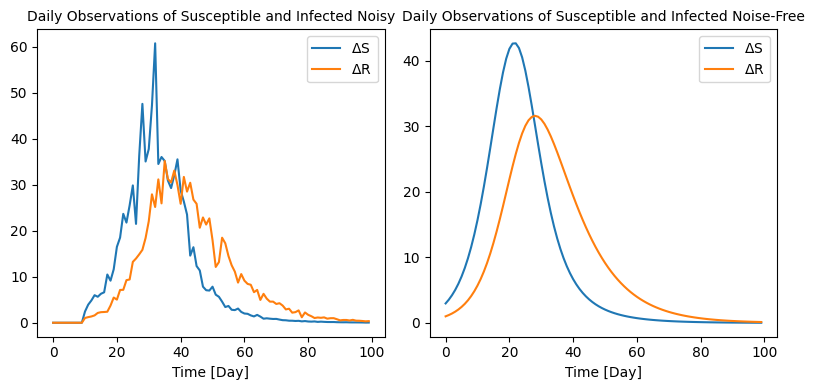

In [18]:
lam = 0.3   # Infection rate
mu = 0.1   # Recovery rate
I_0 = 10    # Initial infected population
L = 10      # Reporting delay
rho = 1   # Underreporting fraction
sigma_2 = 0.02  # Reporting error variance
T = 100      # Time steps
N = 1000    # Total population

observations = simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T, N)

observations_nosie_free, ground_truth = simulate_sir_simple(lam, mu, I_0, N, T)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(observations[:,0], label = "$\Delta$S")
axs[0].plot(observations[:,1], label = "$\Delta$R")
axs[0].set_title("Daily Observations of Susceptible and Infected Noisy", fontsize=10)
axs[0].set_xlabel("Time [Day]")
axs[0].legend()

axs[1].plot(observations_nosie_free[:,0], label = "$\Delta$S")
axs[1].plot(observations_nosie_free[:,1], label = "$\Delta$R")
axs[1].set_title("Daily Observations of Susceptible and Infected Noise-Free", fontsize=10)
axs[1].set_xlabel("Time [Day]")
axs[1].legend()

plt.tight_layout()
plt.show()

<div style="color: green; font-weight:
bold">Comment</div> Correct! Nevertheless, showing the reporting delay, the underreporting fraction and the reporting error variance within the plot would be nice.

In [19]:
class Noisy_SIR_Dataset(Dataset):
    def __init__(self, num_samples, T, N, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior):
        self.num_samples = num_samples
        self.T = T
        self.N = N
        self.lam_prior = lam_prior
        self.mu_prior = mu_prior
        self.I_0_prior = I_0_prior
        self.L_prior = L_prior
        self.rho_prior = rho_prior
        self.sigma_2_prior = sigma_2_prior

        

        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            lam = np.random.normal(self.lam_prior, 0.05)
            mu = np.random.normal(self.mu_prior, 0.01)
            I_0 = max(1, int(np.random.normal(self.I_0_prior, 1)))
            L = max(1, int(np.random.normal(self.L_prior, 1)))
            rho = np.random.normal(self.rho_prior, 0.05)
            sigma_2 = np.random.normal(self.sigma_2_prior, 0.001)
            observations = simulate_sir_noisy(lam, mu, I_0, self.L_prior, self.rho_prior, self.sigma_2_prior, self.T, self.N)
            data.append((observations, [lam, mu, I_0, L, rho, sigma_2]))
        return data
    
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X, Y = self.data[idx]
        return torch.tensor(X, dtype=torch.float32).permute(1, 0), torch.tensor(Y, dtype=torch.float32)

def prepeare_noisy_data(num_samples, T, N, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior, batch_size):
    dataset = Noisy_SIR_Dataset(num_samples, T, N, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size)
    X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])  # Stack all X inputs
    Y_test = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])  # Stack all Y outputs
    return train_dataloader, X_test, Y_test 

Epoch: 0/50, Loss: 259.5461
Epoch: 10/50, Loss: 8.7393
Epoch: 20/50, Loss: 5.6229
Epoch: 30/50, Loss: 4.9294
Epoch: 40/50, Loss: 4.7705
Epoch: 50/50, Loss: 4.7093
Average Error:  0.1929876461625099


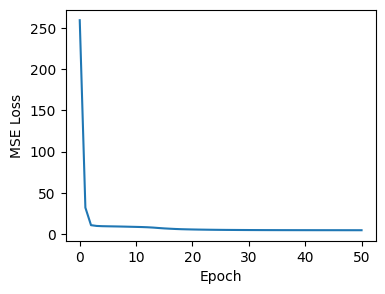

Test Error:  0.19025352597236633


In [20]:
lam_prior = 0.3
mu_prior = 0.1
I_0_prior = 5
L_prior = 10
rho_prior = 1
sigma_2_prior = 0.01
num_samples = 1000
input_size = 2 # Delta S and Delta R
output_size = 6 # lambda, mu, I_0, L, rho and sigma_2
n_layers = 6
hidden_size = 32
batch_size= 32
epochs= 50

train_data, X_test, Y_test = prepeare_noisy_data(num_samples, T, N, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior, batch_size)
model = CNN(input_size, output_size, n_layers, hidden_size, T)
losses, train_loss = train_cnn(model, train_data, epochs, display=True)
test_loss = evaluate_cnn(model, X_test, Y_test)
print("Test Error: ", test_loss)

In [21]:
def evaluate_total_net_noisy(model, X_test, Y_test, num_samples, num_tests):
    idxs = np.random.choice(len(Y_test), num_tests, replace=False)
    for idx in idxs:
        output = model.sample(num_samples, X_test[idx])
        ground_truth = Y_test[idx]

        if num_samples>1:
            fig, axs = plt.subplots(2,7, figsize=(15,5))
            param_names =["lambda", "mu", "I_0", "L", "rho", "sigma_2"]
            handles, labels = [], []
            
            z, log_det_jacob, h_x = model(X_test[idx].unsqueeze(0), Y_test[idx].unsqueeze(0))
            for i, param_name in enumerate(param_names):
                samples = output[:,i].detach().numpy()
                true_value = ground_truth[i].item()

                hist_handle = axs[0, i].hist(samples, bins=30, alpha=0.7, label="Posterior Samples")
                axs[0,i].hist(samples, bins=30, color="tab:blue", alpha=0.7, label="Posterior Samples")
                axs[0,i].axvline(true_value, color="red", linestyle="--", label="True Value")
                axs[0,i].set_title(f"Marginal Distribution of {param_name}", fontsize=7)
                axs[0,i].set_xlabel(param_name)
                axs[0,i].set_ylabel("Frequency")

                # Empirical CDF
                ecdf = ECDF(samples)
                cdf_handle, = axs[1, i].plot(ecdf.x, ecdf.y, label="Empirical CDF")
                axs[1,i].plot(ecdf.x, ecdf.y, color="tab:blue", label="Empirical CDF")
                axs[1,i].axvline(true_value, color="red", linestyle="--")
                axs[1,i].set_title(f"Empirical CDF of {param_name}", fontsize=7)
                axs[1,i].set_xlabel(param_name)
                axs[1,i].set_ylabel("Cumulative Probability")

                # Collect handles and labels for the global legend
                if i == 0:  # Only collect unique labels once
                    handles.append(hist_handle[2][0])  # Histogram handle
                    handles.append(axs[0, i].lines[-1])  # Vertical line for true value
                    handles.append(cdf_handle)  # CDF line
            

            log_probs = model.cond_inn.log_prob(output, h_x.repeat(num_samples, 1))  # Log probability
            energies = -log_probs.detach().numpy()
            true_energy = -model.cond_inn.log_prob(ground_truth.unsqueeze(0), h_x).item()

            # Histogram of joint energies
            axs[0,6].hist(energies, color="tab:blue", bins=30, alpha=0.7)
            axs[0,6].axvline(true_energy, color="red", linestyle="--")
            axs[0,6].set_title("Joint Distribution Energy", fontsize=7)
            axs[0,6].set_xlabel("Energy E(Y)")
            axs[0,6].set_ylabel("Frequency")

            axs[1,6].set_title("3 dim CDF?", fontsize=7)

            fig.legend(handles=handles, labels=["Posterior Samples", "True Value", "Empirical CDF"], loc="upper center", fontsize=10, ncol=3)
            plt.tight_layout(rect=[0, 0, 1, 0.92])
            plt.show()
        else:
            # Handle single sample: Display table
            diff = (output - ground_truth) ** 2
            data = {
                "Parameter": ["lambda", "mu", "I_0", "L", "rho", "sigma_2"],
                "Sampled": output.squeeze().tolist(),
                "Ground Truth": ground_truth.squeeze().tolist(),
                "Error": diff.squeeze().tolist()
            }

            df = pd.DataFrame(data)

            # Display the table
            print("=" * 50)
            print(df)

Epoch: 0/30, Loss: 506.5983
Epoch: 10/30, Loss: -537.5809
Epoch: 20/30, Loss: -643.8554


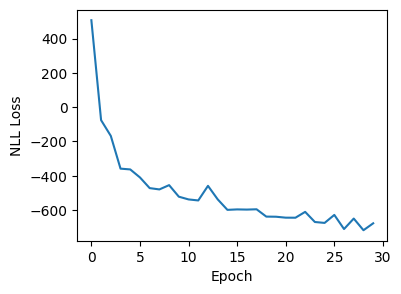

  Parameter   Sampled  Ground Truth     Error
0    lambda  0.303299      0.293516  0.000096
1        mu  0.117296      0.092873  0.000596
2       I_0  3.723728      4.000000  0.076326
3         L  9.870263      9.000000  0.757358
4       rho  1.038484      1.041101  0.000007
5   sigma_2  0.019661      0.008512  0.000124
  Parameter   Sampled  Ground Truth     Error
0    lambda  0.304189      0.242755  0.003774
1        mu  0.116686      0.106498  0.000104
2       I_0  4.235547      7.000000  7.642203
3         L  8.559842     10.000000  2.074055
4       rho  0.976789      0.952203  0.000604
5   sigma_2  0.014682      0.010695  0.000016
  Parameter   Sampled  Ground Truth      Error
0    lambda  0.294689      0.290764   0.000015
1        mu  0.114257      0.097805   0.000271
2       I_0  5.887644      5.000000   0.787912
3         L  7.476716     12.000000  20.460098
4       rho  0.933788      1.078985   0.021082
5   sigma_2  0.013852      0.009396   0.000020
  Parameter   Sampled  Grou

In [22]:
summary_net = SummaryNet(2, 8, 25, 25, 100)
cond_inn = ConditionalRealNVP(6, 64, 10, 25)
Noisy_TotNet = TotalNet(summary_net, cond_inn)
train_dataloader, X_te, Y_te = prepeare_noisy_data(3000, 100, 1000, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior, batch_size)
loss_vals, rec_loss = train_total_net(Noisy_TotNet, train_dataloader, epochs=30, lr=5e-4, display=True)
evaluate_total_net_noisy(Noisy_TotNet, X_te, Y_te, 1, 5)

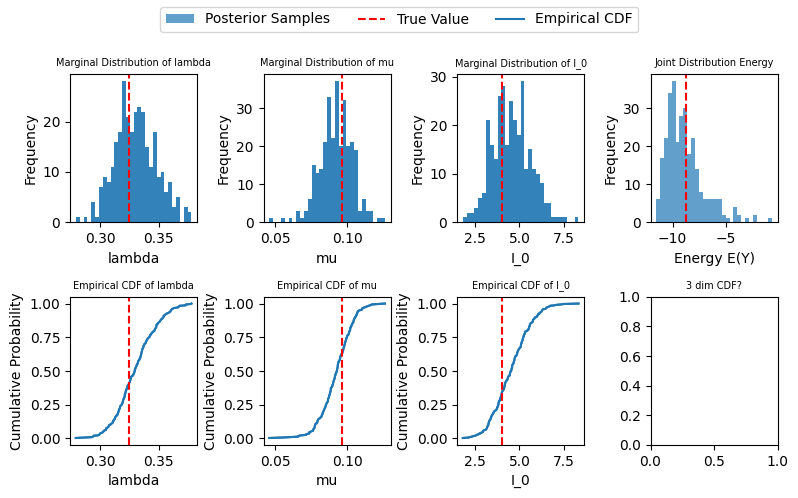

In [23]:
evaluate_total_net(Noisy_TotNet, X_te, Y_te, 300, 1)

Coverage: 99.00%


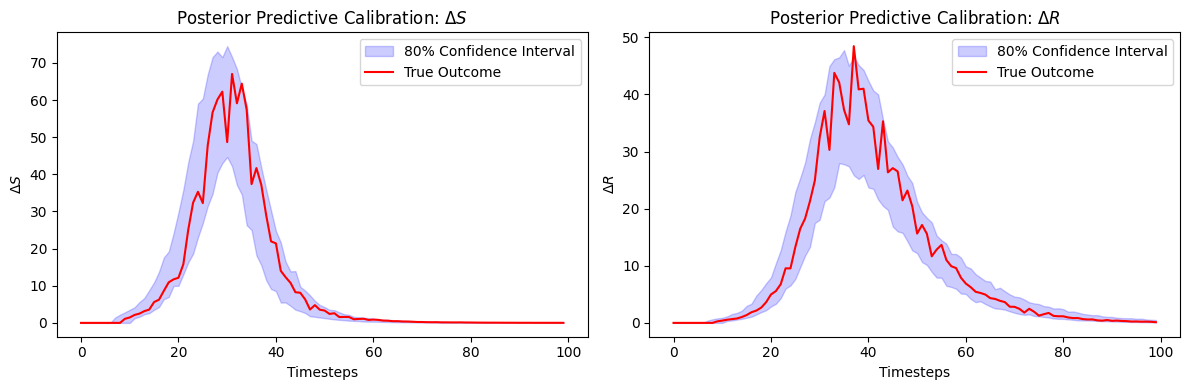

In [24]:
idx = 54
# Sample posterior predictions
post_samples = Noisy_TotNet.sample(100, X_te[idx])

# Extract ground truth parameters
ground_truth = Y_te[idx]
lam, mu, I_0, L, rho, sigma_2 = ground_truth.tolist()

# Simulate true noisy outcome
true_outcome= simulate_sir_noisy(lam, mu, int(I_0), int(L), rho, abs(sigma_2), T, N)
true_outcome = torch.tensor(true_outcome, dtype=torch.float32)

# Resimulate outcomes from posterior samples
resimulated_outcomes = []
for i, Y_k in enumerate(post_samples):
    lam, mu, I_0, L, rho, sigma_2 = Y_k.tolist()
    C_k= simulate_sir_noisy(lam, mu, max(1, int(I_0)), max(1,int(L)), rho, abs(sigma_2), T, N)
    if torch.isnan(torch.tensor(C_k)).any():
        nan_counts = torch.isnan(torch.tensor(C_k)).sum(dim=0)
        print(nan_counts, i)
        print(f"lam: {lam:.2f}, mu: {mu:.2f}, I_0: {I_0:.2f}, L: {L:.2f}, rho: {rho:.2f}, sig: {sigma_2:.2f}")
    resimulated_outcomes.append(torch.tensor(C_k, dtype=torch.float32))  # Ensure 2D output

# Stack outcomes and compute quantiles
resimulated_outcomes = torch.stack(resimulated_outcomes, dim=0)  # Shape: (num_samples, time_steps, 2)
lower_bound = torch.quantile(resimulated_outcomes, 0.05, dim=0)  # Lower bound for 80% CI
upper_bound = torch.quantile(resimulated_outcomes, 0.95, dim=0)  # Upper bound for 80% CI

# Check coverage
is_within_ci = (true_outcome >= lower_bound) & (true_outcome <= upper_bound)
coverage = is_within_ci.float().mean().item()
print(f"Coverage: {coverage * 100:.2f}%")

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
timesteps = torch.arange(resimulated_outcomes.shape[1])

# Plot for Delta S
axs[0].fill_between(
    timesteps.numpy(),  
    lower_bound[:, 0].numpy(),
    upper_bound[:, 0].numpy(),
    color="blue",
    alpha=0.2,
    label="80% Confidence Interval"
)
axs[0].plot(timesteps.numpy(), true_outcome[:, 0].numpy(), color="red", label="True Outcome")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$\Delta S$")
axs[0].set_title("Posterior Predictive Calibration: $\Delta S$")
axs[0].legend()

# Plot for Delta R
axs[1].fill_between(
    timesteps.numpy(),  
    lower_bound[:, 1].numpy(),
    upper_bound[:, 1].numpy(),
    color="blue",
    alpha=0.2,
    label="80% Confidence Interval"
)
axs[1].plot(timesteps.numpy(), true_outcome[:, 1].numpy(), color="red", label="True Outcome")
axs[1].set_xlabel("Timesteps")
axs[1].set_ylabel("$\Delta R$")
axs[1].set_title("Posterior Predictive Calibration: $\Delta R$")
axs[1].legend()

plt.tight_layout()
plt.show()


<div style="color: green; font-weight:
bold">Comment</div> Very nice!!


## 3) Model Misspecification Detection

In [25]:
def mmd_gaussian(x, y, bandwidths=None):
    batch_size = x.size(0)
    
    # Compute pairwise squared Euclidean distances
    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = xx.diag().unsqueeze(0).expand_as(xx)
    ry = yy.diag().unsqueeze(0).expand_as(yy)
    
    xx_dist = rx.t() + rx - 2 * xx
    yy_dist = ry.t() + ry - 2 * yy
    xy_dist = rx.t() + ry - 2 * xy
    
    # Compute the sum of kernels at different bandwidths
    K, L, P = 0, 0, 0
    if bandwidths is None:
        bandwidths = [0.4, 0.8, 1.6]
    for sigma in bandwidths:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * xx_dist)
        L += torch.exp(-gamma * yy_dist)
        P += torch.exp(-gamma * xy_dist)
    
    beta = 1.0 / (batch_size * (batch_size - 1) * len(bandwidths))
    gamma = 2.0 / (batch_size**2 * len(bandwidths))
    return beta * (torch.sum(K) + torch.sum(L)) - gamma * torch.sum(P)

def train_total_net_with_mmd(model, dataloader, epochs=100, lr=5e-4, print_every=10, mmd_weight =1, bandwidths=None, display=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    tot_loss_values = []
    nll_values = []
    mmd_values = []
    for epoch in range(epochs):
        tot_loss = 0
        training_loss = 0
        mmd_training = 0
        for X, Y in dataloader:
            z, log_det_jacob, h_x = model(X, Y)
            nll_loss = torch.mean(1/2 * Y.shape[1] * torch.log(torch.tensor(2*torch.pi)) + 1/2 * torch.sum(z ** 2, dim=1) - log_det_jacob)
            # MMD Loss using mmd_gaussian
            normal_samples = torch.randn_like(h_x)  # Samples from N(0, I) with the same shape as h(X)
            mmd_loss = mmd_gaussian(h_x, normal_samples, bandwidths=bandwidths)
            loss = nll_loss + mmd_weight * mmd_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss += nll_loss.item()
            mmd_training += mmd_loss.item()
            tot_loss = tot_loss + mmd_loss.item() + nll_loss.item()
        nll_values.append(training_loss)
        mmd_values.append(mmd_training)
        tot_loss_values.append(tot_loss)
        if epoch % print_every==0 and display:
            print(f"Epoch: {epoch}/{epochs}, Loss: {training_loss:.4f}")
    
    model.eval()
    rec_loss_total = 0
    for X, Y in dataloader:
        Z, _, h_x = model(X, Y)
        Y_reconstructed = model.cond_inn.reverse(Z, h_x)
        mse_loss = nn.MSELoss()
        rec_loss = mse_loss(Y_reconstructed, Y)
        rec_loss_total += rec_loss.item()

    if display:
        plt.figure(figsize=(4,3))
        plt.plot(tot_loss_values, label="total loss")
        #plt.plot(nll_values, label="NLL")
        #plt.plot(mmd_values, label="MMD")
        plt.ylabel("Losses")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()
    return nll_values, rec_loss_total

def hypo_test(model, X, sig_level=0.01, display=False): 
    h_x = model.summary_net(X)
    chi_squared = torch.sum(h_x**2, dim=1).detach().numpy()  # Assuming unit variance

    # Degrees of freedom (df) = dimension of h(X)
    df = h_x.shape[1]

    # Compute p-values using the chi-squared CDF
    p_values = 1 - stats.chi2.cdf(chi_squared, df=df)

    # Determine whether to reject the null hypothesis for each sample
    reject_null = p_values < sig_level

    # Report results
    #print(f"Proportion of rejected null hypotheses: {reject_null.mean():.2%}")
    if display:
        normal_samples = torch.randn_like(h_x)
        plt.scatter(normal_samples.detach()[:,0], normal_samples.detach()[:,1])
        idxs = np.random.choice(h_x.shape[1], 2, replace=False)
        plt.scatter(h_x.detach()[:,idxs[0]], h_x.detach()[:,idxs[1]])
        plt.xlabel(f"{idxs[0]}th component of feature space")
        plt.ylabel(f"{idxs[1]}th component of feature space")
    
    return reject_null.mean()

Epoch: 0/60, Loss: 407.4042
Epoch: 10/60, Loss: 66.8257
Epoch: 20/60, Loss: 23.3688
Epoch: 30/60, Loss: 5.1771
Epoch: 40/60, Loss: -14.0494
Epoch: 50/60, Loss: -24.9582


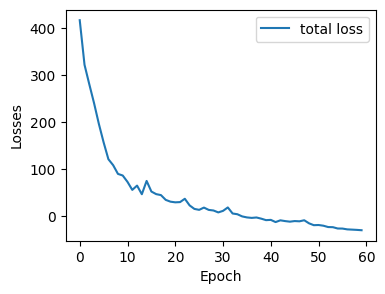

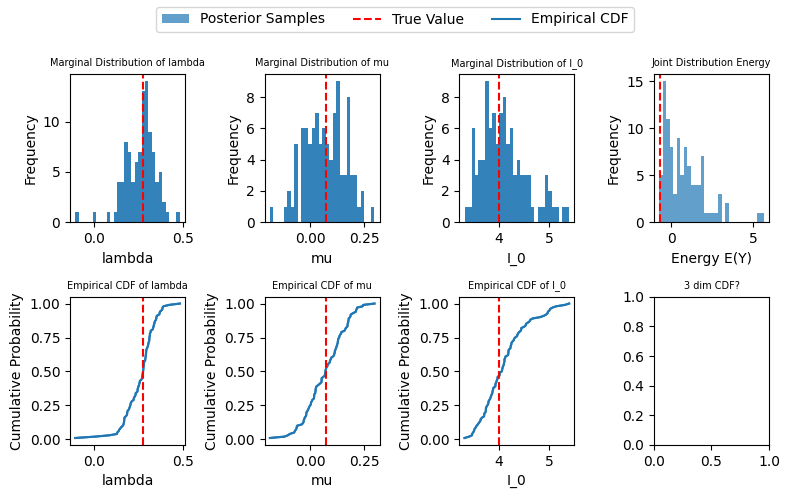

Proportion of rejected null hypotheses: 22.33%


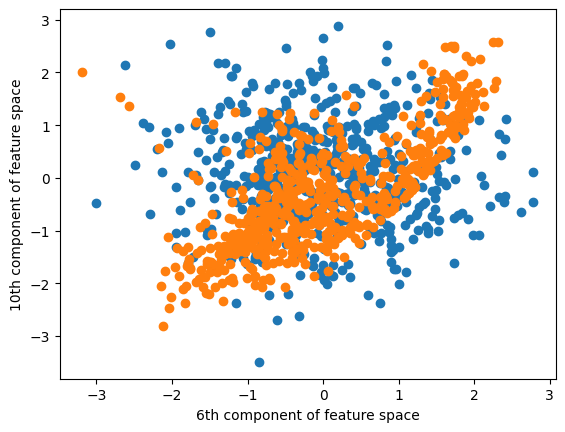

In [26]:
summary_net = SummaryNet(2, 3, 50, 25, 100)
cond_inn = ConditionalRealNVP(3, 50, 5, 25)
TotNet_mmd = TotalNet(summary_net, cond_inn)
train_dataloader, X_test, Y_test = prepeare_data(3000, 100, 1000, lam_prior, mu_prior, I_0_prior,batch_size)
loss_vals, rec_loss = train_total_net_with_mmd(TotNet_mmd, train_dataloader, epochs=60, lr=1e-4, mmd_weight=50, bandwidths=[0.05,1,10], display=True)
evaluate_total_net(TotNet_mmd, X_test, Y_test, 100, 1)
rej = hypo_test(TotNet_mmd, X_test, display=True)
print(f"Proportion of rejected null hypotheses: {rej:.2%}")

<div style="color: green; font-weight:
bold">Comment</div> Mention what orange and blue points stand for within the plot.


This should have had a better result but I couldnt seem to get a perfect score %1, no matter how I train the Summary Network.

Epoch: 0/50, Loss: 1985.0522
Epoch: 10/50, Loss: 27.1767
Epoch: 20/50, Loss: -195.4935
Epoch: 30/50, Loss: -286.1458
Epoch: 40/50, Loss: -342.6362


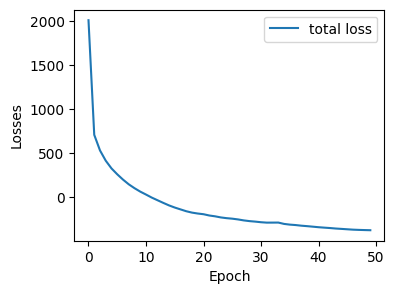

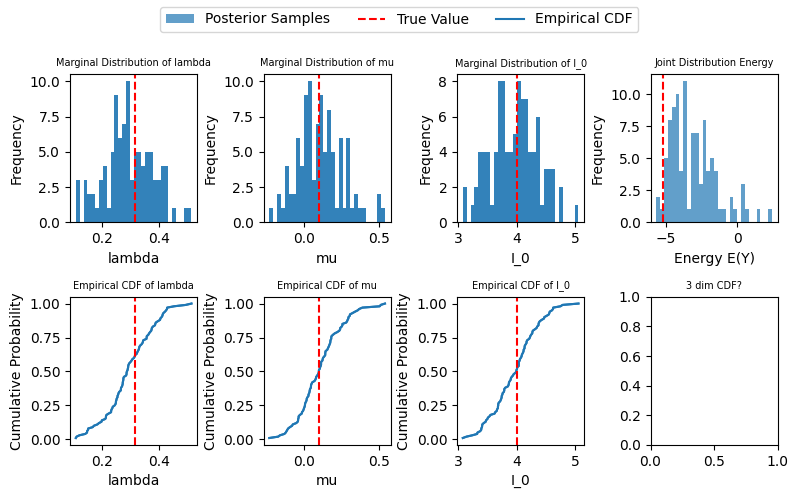

Proportion of rejected null hypotheses: 13.67%


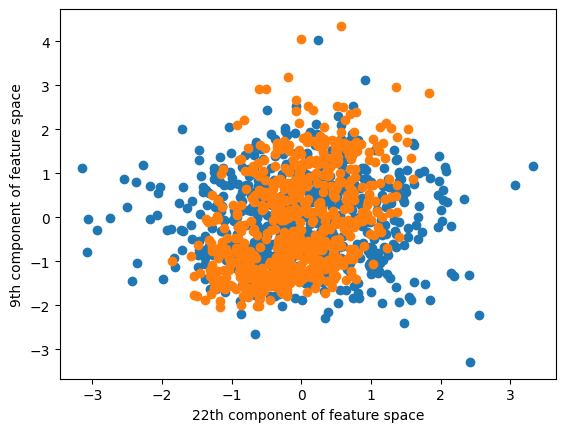

In [27]:
summary_net = SummaryNet(2, 3, 50, 25, 100)
cond_inn = ConditionalRealNVP(6, 50, 5, 25)
Noisy_TotNet_mmd = TotalNet(summary_net, cond_inn)
train_dataloader, X_test, Y_test = prepeare_noisy_data(3000, 100, 1000, lam_prior, mu_prior, I_0_prior, L_prior, rho_prior, sigma_2_prior, batch_size)
loss_vals, rec_loss = train_total_net_with_mmd(Noisy_TotNet_mmd, train_dataloader, epochs=50, lr=1e-4, mmd_weight=50, bandwidths=[0.05,1,10], display=True)
evaluate_total_net(Noisy_TotNet_mmd, X_test, Y_test, 100, 1)
rej = hypo_test(Noisy_TotNet_mmd, X_test, display=True)
print(f"Proportion of rejected null hypotheses: {rej:.2%}")

<div style="color: green; font-weight:
bold">Comment</div> Mention what orange and blue points stand for within the plot.


In [28]:
lam, mu, I_0, L, rho, T, N = 0.1, 0.05, 10, 10, 0.8, 100, 10000
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5]  # Increasing noise variance
test_sizes = [10, 50, 100, 500, 1000]  # Increasing test set sizes


results = []

for sigma_2 in noise_levels:
    for test_size in test_sizes:
        _, X_test, Y_test = prepeare_noisy_data(3000, 100, 1000, lam, mu, I_0, L, rho, sigma_2, batch_size)
        rejection_rate = hypo_test(Noisy_TotNet_mmd, X_test[:test_size])
        results.append({"sigma_2": sigma_2, "test_size": test_size, "rejection_rate": rejection_rate})
        #print(f"Noise Level: {sigma_2}, Test Size: {test_size}, Rejection Rate: {rejection_rate:.2%}")

df_results = pd.DataFrame(results)

print(df_results)

    sigma_2  test_size  rejection_rate
0      0.01         10        0.300000
1      0.01         50        0.260000
2      0.01        100        0.130000
3      0.01        500        0.176000
4      0.01       1000        0.210000
5      0.05         10        0.200000
6      0.05         50        0.200000
7      0.05        100        0.200000
8      0.05        500        0.210000
9      0.05       1000        0.180000
10     0.10         10        0.600000
11     0.10         50        0.280000
12     0.10        100        0.160000
13     0.10        500        0.208000
14     0.10       1000        0.245000
15     0.20         10        0.200000
16     0.20         50        0.380000
17     0.20        100        0.380000
18     0.20        500        0.322000
19     0.20       1000        0.321667
20     0.50         10        0.800000
21     0.50         50        0.580000
22     0.50        100        0.530000
23     0.50        500        0.498000
24     0.50       1000   

With low noise level and low test size $\chi^2$ test will struggle to detect deviations from the standard normal distribution.This is expected because small noise does not significantly distort the data, and small sample sizes reduce statistical power.


With greater sigma values and bigger test sizes our hypothesis test can now detect the mismatches, leading to higher rejection rates. This indicates the model assumptions are strongly violated.

<div style="color: green; font-weight:
bold">Comment</div> Correct conclusions. Still, we cannot see how your first claim is shown with your tests and data above.


## 4) Sensitivity Analysis

<div style="color: green; font-weight:
bold">Comment</div> Missing.
